In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
## need biopython to run: https://anaconda.org/anaconda/biopython
from Bio.SeqUtils import MeltingTemp as mt
from Bio.Seq import Seq
## need OligoArrayAux to run: http://www.unafold.org/Dinamelt/software/OligoArrayAux.php
import oligo_melting as OligoMelt

In [2]:
sns.set()

## Featurization
### Functions
can definitely be improved upon

In [3]:
def letter_at_position(string, letter, position):
    ## takes in a string, letter (both as strings), and position as an integer
    ## returns boolean whether the given letter is at the given position in the string
    return string[position:position+1].__eq__(letter)

def tuple_at_position(string, letters, position):
    ## takes in a string, 2 letters (as a single string) and position as an integer
    ## returns boolean whether the given letters are at the given position in the string
    return string[position:position+2].__eq__(letters)

def triple_at_position(string, letters, position):
    ## takes in a string, 3 letters (as a single string) and position as an integer
    ## returns boolean whether the given letters are at the given position in the string
    return string[position:position+3].__eq__(letters)

def find_PAM(sequence, PAM):
    ## takes in sequence and PAM as strings representing genetic target sequence and the promotospacer-adjacent motif
    ## of the gene editing complex
    ## returns the position as an int or -1 if not found
    match = re.search(PAM, sequence)
    if (match):
        return match.start()
    else:
        return -20

def gc_count(string):
    ## takes in a string
    ## returns an integer representing the number of G or C letters in that string
    count = 0
    for letter in string:
        if letter.__eq__('G') | letter.__eq__('C'):
            count=count+1
    return count

## Shalem et al 2014 DataFrame

In [4]:
df_KO=pd.read_excel("Shalem_KO_data.xlsx")
df_KO.head()

,CCDS ID,Gene name,Exon number,Number of 1bp mismatches,Number of 2bp mismatches,Number of 3bp mismatches,Off-target score (OS),sgRNA sequence
0,CCDS10.1,/TNFRSF18,2,0,0,15,215.2632,TACCCTGGGACTGTACCCCC
1,CCDS10.1,/TNFRSF18,2,0,0,27,304.1053,ACCCTTGCTGCACGACCTGC
2,CCDS10.1,/TNFRSF18,5,0,0,5,60.7368,TCGCTCGCCCCGCTCTTCCT
3,CCDS100.2,/GPR157,2,0,0,6,61.7368,TGACGCCTCGGACGTGTCTG
4,CCDS100.2,/GPR157,2,0,0,7,116.1053,CGTCATAGCCAATCTTCTTC


### Isolating necessary data into one dataframe
- combine only necessary columns into one succinct dataframe
    - include anything that could be useful to models
- plot some graphs to visualize data

In [5]:
df_features=df_KO[["sgRNA sequence","Off-target score (OS)"]]
feature_dict = {"Off-target score (OS)":"sgRNA Score",
                "sgRNA sequence":"Sequence"}
df_features.rename(columns=feature_dict, inplace=True)
df_features["sgRNA Rank"] = df_features["sgRNA Score"].rank(method='max')
n = df_features["sgRNA Rank"].size
# D=(r − 3/8) / (n + 1/4)
df_features["sgRNA Normalized"] = (df_features["sgRNA Rank"] - (3/8)) / (n + 1/4)
df_features.head()

C:\Users\ianha\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-5-9268f50bbdb2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["sgRNA Rank"] = df_features["sgRNA Score"].rank(method='max')
<ipython-input-5-9268f50bbdb2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

,Sequence,sgRNA Score,sgRNA Rank,sgRNA Normalized
0,TACCCTGGGACTGTACCCCC,215.2632,39133.0,0.604353
1,ACCCTTGCTGCACGACCTGC,304.1053,47269.0,0.730003
2,TCGCTCGCCCCGCTCTTCCT,60.7368,14882.0,0.229828
3,TGACGCCTCGGACGTGTCTG,61.7368,15074.0,0.232793
4,CGTCATAGCCAATCTTCTTC,116.1053,25878.0,0.399647


#### Normalization Verification

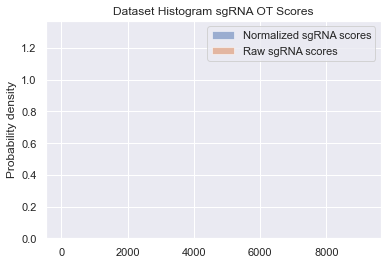

In [6]:
plt.hist(df_features["sgRNA Normalized"], alpha=0.5, density=True, label='Normalized sgRNA scores')
plt.hist(df_features["sgRNA Score"], alpha=0.5, density=True, label='Raw sgRNA scores')
plt.ylabel('Probability density')
plt.title("Dataset Histogram sgRNA OT Scores")
plt.legend()

### V1 Featurization
can definitely be improved upon

In [7]:
df_V1 = df_features.copy(deep=True) ## creates a hard copy of supplementary table 7 data to work with
df_V1['Sequence'] = df_V1['Sequence'].astype('string') ## sets data of sequence to String for parsing
df_V1['Sequence']

0        TACCCTGGGACTGTACCCCC
1        ACCCTTGCTGCACGACCTGC
2        TCGCTCGCCCCGCTCTTCCT
3        TGACGCCTCGGACGTGTCTG
4        CGTCATAGCCAATCTTCTTC
                 ...         
64746    TTGCCGGGTACTACTACGCC
64747    CCGCGCTGTACACCACGACC
64748    CGCGGGGGCAATGCGGGCGC
64749    GCGCTCCTTTACCCTCATCG
64750    GACAACGATACCACCCCGAA
Name: Sequence, Length: 64751, dtype: string

In [8]:
V1_bool_parameters=["GC<10","GC>10"]

for k in range(20):
    ## creates columns for each nucleotide at each position in sequence
    for x in ['A',"G","C","T"]:
        df_V1[x + str(k+1)] = letter_at_position(df_V1['Sequence'],x,k)
        V1_bool_parameters.append(x + str(k+1))
        if k < 19:
            for y in ["A","G","C","T"]:
                df_V1[x + y + str(k+1)] = tuple_at_position(df_V1['Sequence'],x+y,k)
                V1_bool_parameters.append(x + y + str(k+1))
        else:
            for y in ["A","G","C","T"]:
                df_V1[x + y + "?"] =  False # not technically correct but will work as placeholder
                V1_bool_parameters.append(x + y + "?")
        df_V1[x + "?"] = False # same with this
        V1_bool_parameters.append(x + "?")
        
df_V1['GC Count'] = -1 ## creates column for GC count

df_V1['Melting Temp Wallace'] = 0
df_V1['Melting Temp GC'] = 0
df_V1['Melting Temp NN1'] = 0
df_V1['Melting Temp NN2'] = 0
df_V1['Melting Temp NN3'] = 0
df_V1['Melting Temp NN4'] = 0

df_V1["GC<10"] = False
df_V1["GC>10"] = False

In [9]:
for a in range(df_V1['Sequence'].size):
    ## loops through each sequence and computes the necessary one-hot nucleotide encoding features
    for k in range(20):
        for x in ['A',"G","C","T"]:
            df_V1[x + str(k+1)][a] = letter_at_position(df_V1['Sequence'][a],x,k)
            if k < 19:
                for y in ["A","G","C","T"]:
                    df_V1[x + y + str(k+1)][a] = tuple_at_position(df_V1['Sequence'][a],x+y,k)
                    if (not df_V1[x + y + "?"][a]):
                        df_V1[x + y + "?"][a] = df_V1[x + y + str(k+1)][a]

            if (not df_V1[x + "?"][a]):
                df_V1[x + "?"][a] = df_V1[x + str(k+1)][a]

    ## generates the GC count data for each column
    df_V1['GC Count'][a] = gc_count(df_V1['Sequence'][a])

<ipython-input-9-aef352143c4f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_V1[x + y + "?"][a] = df_V1[x + y + str(k+1)][a]
<ipython-input-9-aef352143c4f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_V1[x + "?"][a] = df_V1[x + str(k+1)][a]
<ipython-input-9-aef352143c4f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_V1['GC Count'][a] = gc_count(df_V1['Sequence'][a])


In [10]:
for a in range(df_V1['Sequence'].size):
    seq = Seq(df_V1["Sequence"][a])
    df_V1["Melting Temp Wallace"][a] = mt.Tm_Wallace(seq)
    df_V1["Melting Temp GC"][a] = mt.Tm_GC(seq)
    df_V1["Melting Temp NN1"][a] = mt.Tm_NN(seq, nn_table=mt.DNA_NN1)
    df_V1["Melting Temp NN2"][a] = mt.Tm_NN(seq, nn_table=mt.DNA_NN2)
    df_V1["Melting Temp NN3"][a] = mt.Tm_NN(seq, nn_table=mt.DNA_NN3)
    df_V1["Melting Temp NN4"][a] = mt.Tm_NN(seq, nn_table=mt.DNA_NN4)
    
    df_V1["GC<10"][a] = df_V1["GC Count"][a] < 10
    df_V1["GC>10"][a] = df_V1["GC Count"][a] > 10

<ipython-input-10-0f539409aa5c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_V1["Melting Temp Wallace"][a] = mt.Tm_Wallace(seq)
<ipython-input-10-0f539409aa5c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_V1["Melting Temp GC"][a] = mt.Tm_GC(seq)
<ipython-input-10-0f539409aa5c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_V1["Melting Temp NN1"][a] = mt.Tm_NN(seq, nn_table=mt.DNA_NN1)
<ipython-input-10-0f539409aa5c>:

In [11]:
for v1 in V1_bool_parameters:
    df_V1[v1]=df_V1[v1].astype(int)

In [13]:
df_V1.to_csv('KO_Data_V1_Featurized.csv')
df_V1.head()

,Sequence,sgRNA Score,sgRNA Rank,sgRNA Normalized,A1,AA1,AG1,AC1,AT1,A?,...,TT_PAM,GC Count,Melting Temp Wallace,Melting Temp GC,Melting Temp NN1,Melting Temp NN2,Melting Temp NN3,Melting Temp NN4,GC<10,GC>10
0,TACCCTGGGACTGTACCCCC,215.2632,39133.0,0.604353,0,0,0,0,0,1,...,0,13,66,56,64,58,56,62,0,1
1,ACCCTTGCTGCACGACCTGC,304.1053,47269.0,0.730003,1,0,0,1,0,1,...,0,13,66,56,68,63,59,61,0,1
2,TCGCTCGCCCCGCTCTTCCT,60.7368,14882.0,0.229828,0,0,0,0,0,0,...,0,14,68,58,74,67,62,64,0,1
3,TGACGCCTCGGACGTGTCTG,61.7368,15074.0,0.232793,0,0,0,0,0,1,...,0,13,66,56,67,63,58,59,0,1
4,CGTCATAGCCAATCTTCTTC,116.1053,25878.0,0.399647,0,0,0,0,0,1,...,0,9,58,48,55,53,48,49,1,0


### V2 Featurization
can definitely be improved upon

In [14]:
df_V2 = df_V1.copy(deep=True)
V2_bool_parameters=V1_bool_parameters

In [15]:
df_V2["AAAAA"] = "AAAAA" in df_V2["Sequence"] ## initializes each column to false
df_V2["GGGGG"] = "GGGGG" in df_V2["Sequence"]
df_V2["CCCCC"] = "CCCCC" in df_V2["Sequence"]
df_V2["TTTTT"] = "TTTTT" in df_V2["Sequence"]
V2_bool_parameters.append(["AAAAA","GGGGG","CCCCC","TTTTT"])
df_V2.head()

,Sequence,sgRNA Score,sgRNA Rank,sgRNA Normalized,A1,AA1,AG1,AC1,AT1,A?,...,Melting Temp NN1,Melting Temp NN2,Melting Temp NN3,Melting Temp NN4,GC<10,GC>10,AAAAA,GGGGG,CCCCC,TTTTT
0,TACCCTGGGACTGTACCCCC,215.2632,39133.0,0.604353,0,0,0,0,0,1,...,64,58,56,62,0,1,False,False,False,False
1,ACCCTTGCTGCACGACCTGC,304.1053,47269.0,0.730003,1,0,0,1,0,1,...,68,63,59,61,0,1,False,False,False,False
2,TCGCTCGCCCCGCTCTTCCT,60.7368,14882.0,0.229828,0,0,0,0,0,0,...,74,67,62,64,0,1,False,False,False,False
3,TGACGCCTCGGACGTGTCTG,61.7368,15074.0,0.232793,0,0,0,0,0,1,...,67,63,58,59,0,1,False,False,False,False
4,CGTCATAGCCAATCTTCTTC,116.1053,25878.0,0.399647,0,0,0,0,0,1,...,55,53,48,49,1,0,False,False,False,False


In [16]:
for k in range(19):
    for x in ['A',"G","C","T"]:
        for y in ['A',"G","C","T"]:
            for z in ["A","G","C","T"]:
                
                if k < 18:
                    df_V2[x + y + z + str(k+1)] = False
                    V2_bool_parameters.append(x + y + z + str(k+1))
                else:
                    df_V2[x+y+z] = False
                    V2_bool_parameters.append(x+y+z)
df_V2["Delta G"] = 0
df_V2.head()

,Sequence,sgRNA Score,sgRNA Rank,sgRNA Normalized,A1,AA1,AG1,AC1,AT1,A?,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,Delta G
0,TACCCTGGGACTGTACCCCC,215.2632,39133.0,0.604353,0,0,0,0,0,1,...,False,False,False,False,False,False,False,False,False,0
1,ACCCTTGCTGCACGACCTGC,304.1053,47269.0,0.730003,1,0,0,1,0,1,...,False,False,False,False,False,False,False,False,False,0
2,TCGCTCGCCCCGCTCTTCCT,60.7368,14882.0,0.229828,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
3,TGACGCCTCGGACGTGTCTG,61.7368,15074.0,0.232793,0,0,0,0,0,1,...,False,False,False,False,False,False,False,False,False,0
4,CGTCATAGCCAATCTTCTTC,116.1053,25878.0,0.399647,0,0,0,0,0,1,...,False,False,False,False,False,False,False,False,False,0


In [17]:
for a in range(df_V2['Sequence'].size):
    df_V2["AAAAA"][a] = "AAAAA" in df_V2["Sequence"][a]
    df_V2["GGGGG"][a] = "GGGGG" in df_V2["Sequence"][a]
    df_V2["CCCCC"][a] = "CCCCC" in df_V2["Sequence"][a]
    df_V2["TTTTT"][a] = "TTTTT" in df_V2["Sequence"][a]
    
    for k in range(19):
        for x in ['A',"G","C","T"]:
            for y in ['A',"G","C","T"]:
                for z in ["A","G","C","T"]:

                    if k < 18:
                        df_V2[x + y + z + str(k+1)][a] = triple_at_position(df_V2["Sequence"][a], x+y+z, k)
                        if (not df_V2[x+y+z][a]):
                            df_V2[x+y+z][a] = df_V2[x + y + z + str(k+1)][a]

<ipython-input-17-24cf5289d21e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_V2["AAAAA"][a] = "AAAAA" in df_V2["Sequence"][a]
<ipython-input-17-24cf5289d21e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_V2["GGGGG"][a] = "GGGGG" in df_V2["Sequence"][a]
<ipython-input-17-24cf5289d21e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_V2["CCCCC"][a] = "CCCCC" in df_V2["Sequence"][a]
<ipython-input-17-24cf5289d21e>:5: Setti

In [18]:
for a in range(df_V2['Sequence'].size):
    ## note that this uses the 20-n.t. guide RNA sequence
    ## all previously calculated features use the 30-oligo target sequence
    
    # # Calculate melting temperature for 25uM oligos
    # (name, g, h, s, tm, seq)
    df_V2["Delta G"][a] = OligoMelt.Duplex.calc_tm(df_V2["Sequence"][a])[1]

<ipython-input-18-84596af6d52e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_V2["Delta G"][a] = OligoMelt.Duplex.calc_tm(df_V2["Sequence"][a])[1]


In [19]:
for v2 in V2_bool_parameters:
    df_V2[v2]=df_V2[v2].astype(int)

In [20]:
df_V2.to_csv('KO_Data_V2_Featurized.csv')
df_V2.head()

,Sequence,sgRNA Score,sgRNA Rank,sgRNA Normalized,A1,AA1,AG1,AC1,AT1,A?,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,Delta G
0,TACCCTGGGACTGTACCCCC,215.2632,39133.0,0.604353,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,-26
1,ACCCTTGCTGCACGACCTGC,304.1053,47269.0,0.730003,1,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,-28
2,TCGCTCGCCCCGCTCTTCCT,60.7368,14882.0,0.229828,0,0,0,0,0,0,...,0,0,1,1,1,0,0,1,0,-29
3,TGACGCCTCGGACGTGTCTG,61.7368,15074.0,0.232793,0,0,0,0,0,1,...,1,0,1,0,1,0,0,0,0,-28
4,CGTCATAGCCAATCTTCTTC,116.1053,25878.0,0.399647,0,0,0,0,0,1,...,0,1,0,0,1,0,0,1,0,-23


### V3

In [ ]:
# to do